In [1]:
from casadi import *
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(24)

First creating the data, a simple non linear equation

In [30]:
#input data
x=np.linspace(-2,2,40).reshape(-1,1)
#target data
y=x**2+np.sin(x*3)*4+np.random.randn(x.shape[0],1)*0.3

hidden_layer_size=6
LR=0.01 #learning rate

Creating the basic stucture of a neural network

Symbolic placeholders for the weights, an activation function, a cost function and the neural network operations

In [3]:

blank=MX.sym('blank')
input_NN=MX.sym('input',x.shape[0],x.shape[1])
output_NN=MX.sym('output',x.shape[0],x.shape[1])
target=MX.sym('target',y.shape[0],y.shape[1])
#neuron_weights=MX.sym('neuron_weights')
hidden_layer_weights=MX.sym('HL_weights',x.shape[1],hidden_layer_size)
output_layer_weights=MX.sym('OL_weights',hidden_layer_size,y.shape[1])
hidden_layer_bias=MX.sym('HL_bias',hidden_layer_size,1)
output_layer_bias=MX.sym('OL_bias',y.shape[1],1)

logistic_activation=Function('logistic_f',[blank],[1/(1+exp(-blank))])
cost_function=Function('euclid_dist',[output_NN,target],[(output_NN-target)**2])

hidden_layer=logistic_activation((input_NN@hidden_layer_weights)+(DM.ones(x.shape[0],hidden_layer_size)@diag(hidden_layer_bias)))
output_layer=(hidden_layer@output_layer_weights)+(DM.ones(x.shape[0],y.shape[1])@diag(output_layer_bias))
error=cost_function(output_layer,y)


Now we write the NN activation and the gradient equations as functions

In [4]:
activate_NN=Function('neural_network_activation',[input_NN,hidden_layer_weights,hidden_layer_bias,output_layer_weights,output_layer_bias],[output_layer])

grad_HL_weights=Function('grad_HL_weights',[input_NN,hidden_layer_weights,hidden_layer_bias,output_layer_weights,output_layer_bias],[jacobian(error,hidden_layer_weights)])
grad_OL_weights=Function('grad_HL_weights',[input_NN,hidden_layer_weights,hidden_layer_bias,output_layer_weights,output_layer_bias],[jacobian(error,output_layer_weights)])
grad_HL_bias=Function('grad_HL_weights',[input_NN,hidden_layer_weights,hidden_layer_bias,output_layer_weights,output_layer_bias],[jacobian(error,hidden_layer_bias)])
grad_OL_bias=Function('grad_HL_weights',[input_NN,hidden_layer_weights,hidden_layer_bias,output_layer_weights,output_layer_bias],[jacobian(error,output_layer_bias)])


#

Initializng the weights

In [5]:
HL_bias_num=DM.zeros(hidden_layer_size,1)
OL_bias_num=DM([0])
HL_weights_num=DM(np.random.randn(hidden_layer_size)*0.5)
OL_weights_num=DM(np.random.randn(y.shape[1])*0.5)



Here we check what the untrained Neural network outputs

Text(0.5, 1.0, 'Error = 11.618529')

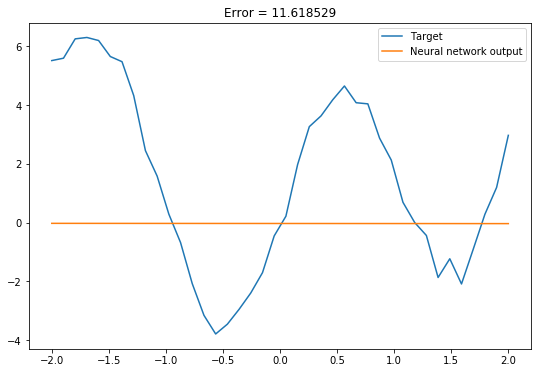

In [6]:
y_hat=activate_NN(x,HL_weights_num,HL_bias_num,OL_weights_num,OL_bias_num)
plt.figure(figsize=(9,6));plt.plot(x,y,x,y_hat);plt.legend(['Target','Neural network output'])
plt.title('Error = {0:f}'.format(np.mean((y_hat-y)**2)))

# Here we train the NN with a simple gradient descent algorithm

$w^k =w^{k-1} -LR* \frac{dE}{dw}$

In [7]:
n_epochs=40000

for i in range(n_epochs):
    grad_HLW=grad_HL_weights(x,HL_weights_num,HL_bias_num,OL_weights_num,OL_bias_num)
    grad_OLW=grad_OL_weights(x,HL_weights_num,HL_bias_num,OL_weights_num,OL_bias_num)
    grad_HLB=grad_HL_bias(x,HL_weights_num,HL_bias_num,OL_weights_num,OL_bias_num)
    grad_OLB=grad_OL_bias(x,HL_weights_num,HL_bias_num,OL_weights_num,OL_bias_num)
    
    HL_weights_num=HL_weights_num-LR*np.mean(grad_HLW,axis=0)
    OL_weights_num=OL_weights_num-LR*np.mean(grad_OLW,axis=0)
    HL_bias_num=HL_bias_num-LR*np.mean(grad_HLB,axis=0)
    OL_bias_num=OL_bias_num-LR*np.mean(grad_OLB,axis=0)
    


Text(0.5, 1.0, 'Error = 0.636568')

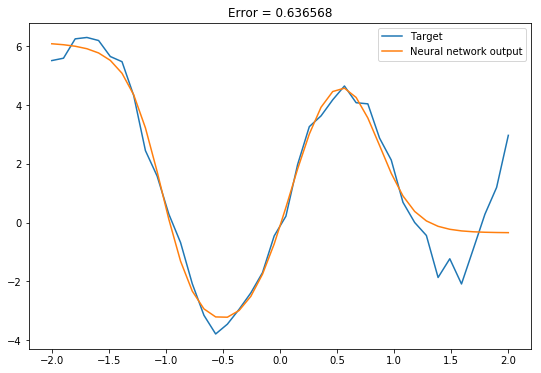

In [8]:
y_hat=activate_NN(x,HL_weights_num,HL_bias_num,OL_weights_num,OL_bias_num)
plt.figure(figsize=(9,6));plt.plot(x,y,x,y_hat);plt.legend(['Target','Neural network output'])
plt.title('Error = {0:f}'.format(np.mean((y_hat-y)**2)))

# Now we add a little bit of regularization, in this case L2 regularization, also known as weight decay, to demonstrate how easy it is to make changes in CASADI

In [9]:
print('sum of the squares of the weights is  %2.3f for the hiddel layer weights and  %2.3f for the output layer weights' %(sumsqr(HL_weights_num),sumsqr(OL_weights_num)))

sum of the squares of the weights is  161.301 for the hiddel layer weights and  259.328 for the output layer weights


In [47]:
L2=0.001
cost_function_L2=Function('euclid_dist_plus_L2',[output_NN,target,hidden_layer_weights,output_layer_weights],[(output_NN-target)**2+
                                                                                                   L2*(sumsqr(hidden_layer_weights)+sumsqr(output_layer_weights))])
error_L2=cost_function_L2(output_layer,y,hidden_layer_weights,output_layer_weights)

grad_HL_weights=Function('grad_HL_weights',[input_NN,hidden_layer_weights,hidden_layer_bias,output_layer_weights,output_layer_bias],[jacobian(error_L2,hidden_layer_weights)])
grad_OL_weights=Function('grad_HL_weights',[input_NN,hidden_layer_weights,hidden_layer_bias,output_layer_weights,output_layer_bias],[jacobian(error_L2,output_layer_weights)])
grad_HL_bias=Function('grad_HL_weights',[input_NN,hidden_layer_weights,hidden_layer_bias,output_layer_weights,output_layer_bias],[jacobian(error_L2,hidden_layer_bias)])
grad_OL_bias=Function('grad_HL_weights',[input_NN,hidden_layer_weights,hidden_layer_bias,output_layer_weights,output_layer_bias],[jacobian(error_L2,output_layer_bias)])


Reinitializing the layers

In [48]:
HL_bias_num=DM.zeros(hidden_layer_size,1)
OL_bias_num=DM([0])
HL_weights_num=DM(np.random.randn(hidden_layer_size)*0.5)
OL_weights_num=DM(np.random.randn(y.shape[1])*0.5)

#output_hidden_layer=NN_layer(hidden_layer_weights,hidden_layer_bias,x)

Text(0.5, 1.0, 'Error = 16.326920')

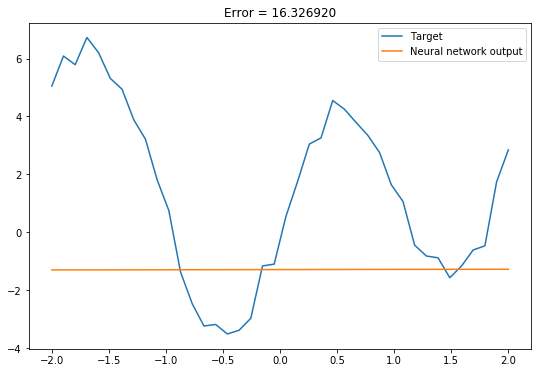

In [49]:
y_hat=activate_NN(x,HL_weights_num,HL_bias_num,OL_weights_num,OL_bias_num)
plt.figure(figsize=(9,6));plt.plot(x,y,x,y_hat);plt.legend(['Target','Neural network output'])
plt.title('Error = {0:f}'.format(np.mean((y_hat-y)**2)))

In [50]:
n_epochs=40000

for i in range(n_epochs):
    grad_HLW=grad_HL_weights(x,HL_weights_num,HL_bias_num,OL_weights_num,OL_bias_num)
    grad_OLW=grad_OL_weights(x,HL_weights_num,HL_bias_num,OL_weights_num,OL_bias_num)
    grad_HLB=grad_HL_bias(x,HL_weights_num,HL_bias_num,OL_weights_num,OL_bias_num)
    grad_OLB=grad_OL_bias(x,HL_weights_num,HL_bias_num,OL_weights_num,OL_bias_num)
    
    HL_weights_num=HL_weights_num-LR*np.mean(grad_HLW,axis=0)
    OL_weights_num=OL_weights_num-LR*np.mean(grad_OLW,axis=0)
    HL_bias_num=HL_bias_num-LR*np.mean(grad_HLB,axis=0)
    OL_bias_num=OL_bias_num-LR*np.mean(grad_OLB,axis=0)
    


Text(0.5, 1.0, 'Error = 0.559200')

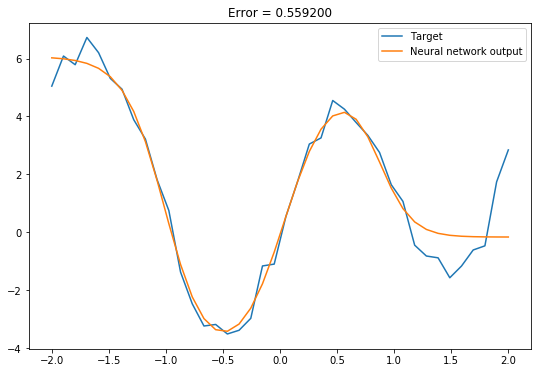

In [51]:
y_hat=activate_NN(x,HL_weights_num,HL_bias_num,OL_weights_num,OL_bias_num)
plt.figure(figsize=(9,6));plt.plot(x,y,x,y_hat);plt.legend(['Target','Neural network output'])
plt.title('Error = {0:f}'.format(np.mean((y_hat-y)**2)))

In [52]:
print('sum of the squares of the weights is  %2.3f for the hiddel layer weights and  %2.3f for the output layer weights' %(sumsqr(HL_weights_num),sumsqr(OL_weights_num)))

sum of the squares of the weights is  163.077 for the hiddel layer weights and  143.234 for the output layer weights


# Now we will optimize it using the IPOPT package that comes with casadi

In [64]:
#first we flat and concateate the weights and the biases
var=vertcat(reshape(hidden_layer_weights,-1,1),reshape(hidden_layer_bias,-1,1),reshape(output_layer_weights,-1,1),reshape(output_layer_bias,-1,1))

#total cost function will be the sum of each individual cost function
f=sum1(cost_function_L2(activate_NN(x,hidden_layer_weights,hidden_layer_bias,output_layer_weights,output_layer_bias),y,hidden_layer_weights,output_layer_weights))


In [65]:
nlp = {'x':var, 'f':f}
S = nlpsol('S', 'ipopt', nlp)
sol = S(x0=np.random.randn(19)*0.5, lbg=0, ubg=0)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      190

Total number of variables............................:       19
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6

Text(0.5, 1.0, 'Error = 0.136557')

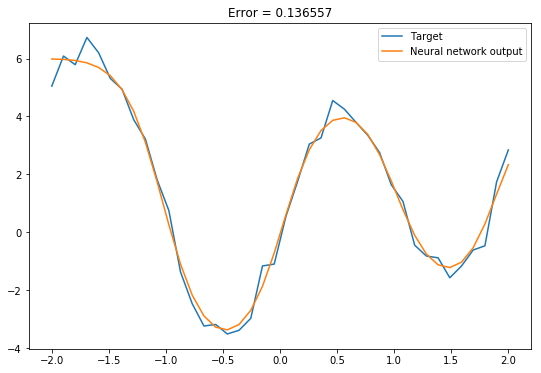

In [63]:
sol['x']
HL_weights_num=sol['x'].full()[:6];
HL_bias_num=sol['x'].full()[6:12];
OL_weights_num=sol['x'].full()[12:18];
OL_bias_num=sol['x'].full()[18];
y_hat=activate_NN(x,HL_weights_num,HL_bias_num,OL_weights_num,OL_bias_num)
plt.figure(figsize=(9,6));plt.plot(x,y,x,y_hat);plt.legend(['Target','Neural network output'])
plt.title('Error = {0:f}'.format(np.mean((y_hat-y)**2)))

## This the end of this small tutorial As we can see it is possible to run 